In [ ]:
!sudo add-apt-repository ppa:deadsnakes/ppa -y
!sudo apt-get update -y
!sudo apt-get install python3.12 python3.12-venv python3.12-dev -y
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.12 2
!sudo update-alternatives --set python3 /usr/bin/python3.12
!python3 -m ensurepip
!python3 -m pip install --upgrade pip
!python -V

Repository: 'deb https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu/ jammy main'
Description:
This PPA contains more recent Python versions packaged for Ubuntu.

Disclaimer: there's no guarantee of timely updates in case of security problems or other issues. If you want to use them in a security-or-otherwise-critical environment (say, on a production server), you do so at your own risk.

Update Note
Please use this repository instead of ppa:fkrull/deadsnakes.

Reporting Issues

Issues can be reported in the master issue tracker at:
https://github.com/deadsnakes/issues/issues

Supported Ubuntu and Python Versions

- Ubuntu 20.04 (focal) Python3.5 - Python3.7, Python3.9 - Python3.13
- Ubuntu 22.04 (jammy) Python3.7 - Python3.9, Python3.11 - Python3.13
- Ubuntu 24.04 (noble) Python3.7 - Python3.11, Python3.13
- Note: Python2.7 (focal, jammy), Python 3.8 (focal), Python 3.10 (jammy), Python3.12 (noble) are not provided by deadsnakes as upstream ubuntu provides those packages.

Why some

In [ ]:
!mkdir -p /content/pokemon_images

In [ ]:
!unzip -q /content/images.zip -d /content/pokemon_images

In [ ]:
!pip install datasets==2.14.4

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 139.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31/31 [datasets]


In [ ]:
from datasets import load_dataset, DatasetDict
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision import transforms, datasets
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm.notebook import tqdm
from PIL import Image
import random
import matplotlib.pyplot as plt

In [ ]:
data_dir = "/content/pokemon_images/images"
full_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=None
)

class RawPokemonDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.resize = transforms.Resize((128, 128))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = transforms.ToTensor()(img)
        img = self.resize(img)
        return img, label

dataset = RawPokemonDataset(full_dataset)

In [ ]:
random.seed(42)
torch.manual_seed(42)
train_frac = 0.8
val_frac   = 0.1
test_frac  = 0.1
total_len = len(full_dataset)
total_len

2503

In [ ]:
train_len = int(train_frac * total_len)
val_len   = int(val_frac * total_len)
test_len  = total_len - train_len - val_len
indices = list(range(total_len))
random.shuffle(indices)
train_indices = indices[:train_len]
val_indices   = indices[train_len:train_len + val_len]
test_indices  = indices[train_len + val_len:]

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
val_test_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
full_dataset_train = datasets.ImageFolder(root=data_dir, transform=train_transform)
full_dataset_val_test = datasets.ImageFolder(root=data_dir, transform=val_test_transform)
train_dataset = Subset(full_dataset_train, train_indices)
val_dataset   = Subset(full_dataset_val_test, val_indices)
test_dataset  = Subset(full_dataset_val_test, test_indices)
print(f"Train size: {len(train_dataset)}")
print(f"Val   size: {len(val_dataset)}")
print(f"Test  size: {len(test_dataset)}")

Train size: 2002
Val   size: 250
Test  size: 251


In [ ]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используем устройство:", device)

class SimplePokemonCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimplePokemonCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                  # 128 → 64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                  # 64 → 32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                  # 32 → 16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


num_classes = len(full_dataset.classes)
model = SimplePokemonCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Используем устройство: cpu


In [ ]:
writer = SummaryWriter(log_dir="runs/pokemon_experiment")
print("TensorBoard логи будут писаться в папку runs/pokemon_experiment")

sample_inputs, _ = next(iter(train_loader))
writer.add_graph(model, sample_inputs.to(device))

TensorBoard логи будут писаться в папку runs/pokemon_experiment


In [ ]:
num_epochs = 20

train_losses, val_losses = [], []
train_accs,  val_accs   = [], []

best_val_loss = float("inf")
best_model_path = "best_pokemon_cnn.pth"

for epoch in range(num_epochs):
    # ------- Train -------
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]", leave=False)
    for batch_idx, (inputs, labels) in enumerate(loop):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()
        running_total += labels.size(0)

        loop.set_postfix({
            "loss": f"{running_loss/running_total:.4f}",
            "acc":  f"{running_corrects/running_total:.4f}"
        })

        if batch_idx % 100 == 0:
            img_grid = torchvision.utils.make_grid(inputs[:16].cpu(), normalize=True, scale_each=True)
            writer.add_image(f"Train/Images_epoch{epoch+1}_batch{batch_idx}", img_grid, epoch)

    epoch_train_loss = running_loss / running_total
    epoch_train_acc  = running_corrects / running_total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    writer.add_scalar("Loss/train", epoch_train_loss, epoch)
    writer.add_scalar("Accuracy/train", epoch_train_acc, epoch)

    # ------- Validation -------
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_running_total = 0

    with torch.no_grad():
        loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]  ", leave=False)
        for batch_idx, (inputs, labels) in enumerate(loop):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, dim=1)
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels).item()
            val_running_total += labels.size(0)

            loop.set_postfix({
                "loss": f"{val_running_loss/val_running_total:.4f}",
                "acc":  f"{val_running_corrects/val_running_total:.4f}"
            })

            if batch_idx % 100 == 0:
                img_grid = torchvision.utils.make_grid(inputs[:16].cpu(), normalize=True, scale_each=True)
                writer.add_image(f"Val/Images_epoch{epoch+1}_batch{batch_idx}", img_grid, epoch)

    epoch_val_loss = val_running_loss / val_running_total
    epoch_val_acc  = val_running_corrects / val_running_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    writer.add_scalar("Loss/val", epoch_val_loss, epoch)
    writer.add_scalar("Accuracy/val", epoch_val_acc, epoch)

    print(
        f"Epoch {epoch+1}/{num_epochs} → "
        f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
        f"Val   Loss: {epoch_val_loss:.4f}, Val   Acc: {epoch_val_acc:.4f}"
    )

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"  → Сохранили лучшую модель: val_loss={best_val_loss:.4f}")

writer.close()

Epoch 1/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/20 → Train Loss: 6.8124, Train Acc: 0.0010 | Val   Loss: 6.8040, Val   Acc: 0.0000
  → Сохранили лучшую модель: val_loss=6.8040


Epoch 2/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/20 → Train Loss: 6.7906, Train Acc: 0.0020 | Val   Loss: 6.8065, Val   Acc: 0.0000


Epoch 3/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/20 → Train Loss: 6.7668, Train Acc: 0.0015 | Val   Loss: 6.8356, Val   Acc: 0.0040


Epoch 4/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/20 → Train Loss: 6.7272, Train Acc: 0.0055 | Val   Loss: 6.8128, Val   Acc: 0.0000


Epoch 5/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/20 → Train Loss: 6.6379, Train Acc: 0.0070 | Val   Loss: 6.8115, Val   Acc: 0.0040


Epoch 6/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6/20 → Train Loss: 6.5267, Train Acc: 0.0115 | Val   Loss: 6.7951, Val   Acc: 0.0120
  → Сохранили лучшую модель: val_loss=6.7951


Epoch 7/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7/20 → Train Loss: 6.3658, Train Acc: 0.0190 | Val   Loss: 6.7350, Val   Acc: 0.0080
  → Сохранили лучшую модель: val_loss=6.7350


Epoch 8/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8/20 → Train Loss: 6.1279, Train Acc: 0.0375 | Val   Loss: 6.7847, Val   Acc: 0.0160


Epoch 9/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9/20 → Train Loss: 5.8692, Train Acc: 0.0514 | Val   Loss: 6.7226, Val   Acc: 0.0360
  → Сохранили лучшую модель: val_loss=6.7226


Epoch 10/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/20 → Train Loss: 5.5690, Train Acc: 0.0839 | Val   Loss: 6.7093, Val   Acc: 0.0360
  → Сохранили лучшую модель: val_loss=6.7093


Epoch 11/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11/20 → Train Loss: 5.2689, Train Acc: 0.0999 | Val   Loss: 6.6188, Val   Acc: 0.0520
  → Сохранили лучшую модель: val_loss=6.6188


Epoch 12/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12/20 → Train Loss: 4.9325, Train Acc: 0.1204 | Val   Loss: 6.6034, Val   Acc: 0.0520
  → Сохранили лучшую модель: val_loss=6.6034


Epoch 13/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13/20 → Train Loss: 4.6081, Train Acc: 0.1568 | Val   Loss: 6.4430, Val   Acc: 0.0640
  → Сохранили лучшую модель: val_loss=6.4430


Epoch 14/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14/20 → Train Loss: 4.3054, Train Acc: 0.2083 | Val   Loss: 6.5109, Val   Acc: 0.0640


Epoch 15/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15/20 → Train Loss: 3.9932, Train Acc: 0.2313 | Val   Loss: 6.4171, Val   Acc: 0.0760
  → Сохранили лучшую модель: val_loss=6.4171


Epoch 16/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16/20 → Train Loss: 3.7057, Train Acc: 0.2822 | Val   Loss: 6.4129, Val   Acc: 0.0760
  → Сохранили лучшую модель: val_loss=6.4129


Epoch 17/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17/20 → Train Loss: 3.3748, Train Acc: 0.3227 | Val   Loss: 6.3486, Val   Acc: 0.0880
  → Сохранили лучшую модель: val_loss=6.3486


Epoch 18/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18/20 → Train Loss: 3.1478, Train Acc: 0.3467 | Val   Loss: 6.3603, Val   Acc: 0.1040


Epoch 19/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19/20 → Train Loss: 2.8918, Train Acc: 0.3956 | Val   Loss: 6.4419, Val   Acc: 0.1040


Epoch 20/20 [TRAIN]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/20 [VAL]  :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20/20 → Train Loss: 2.5968, Train Acc: 0.4441 | Val   Loss: 6.4160, Val   Acc: 0.1120


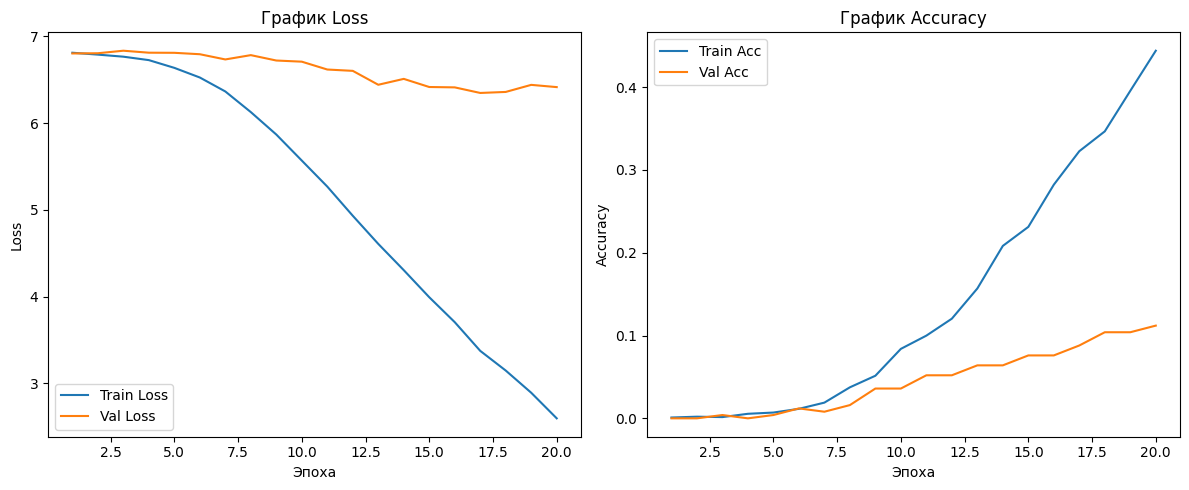

In [ ]:
epochs_range = list(range(1, num_epochs + 1))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses,   label="Val Loss")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("График Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs,   label="Val Acc")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title("График Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

TEST evaluation:   0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Test Loss: 7.2665, Test Accuracy: 0.0637



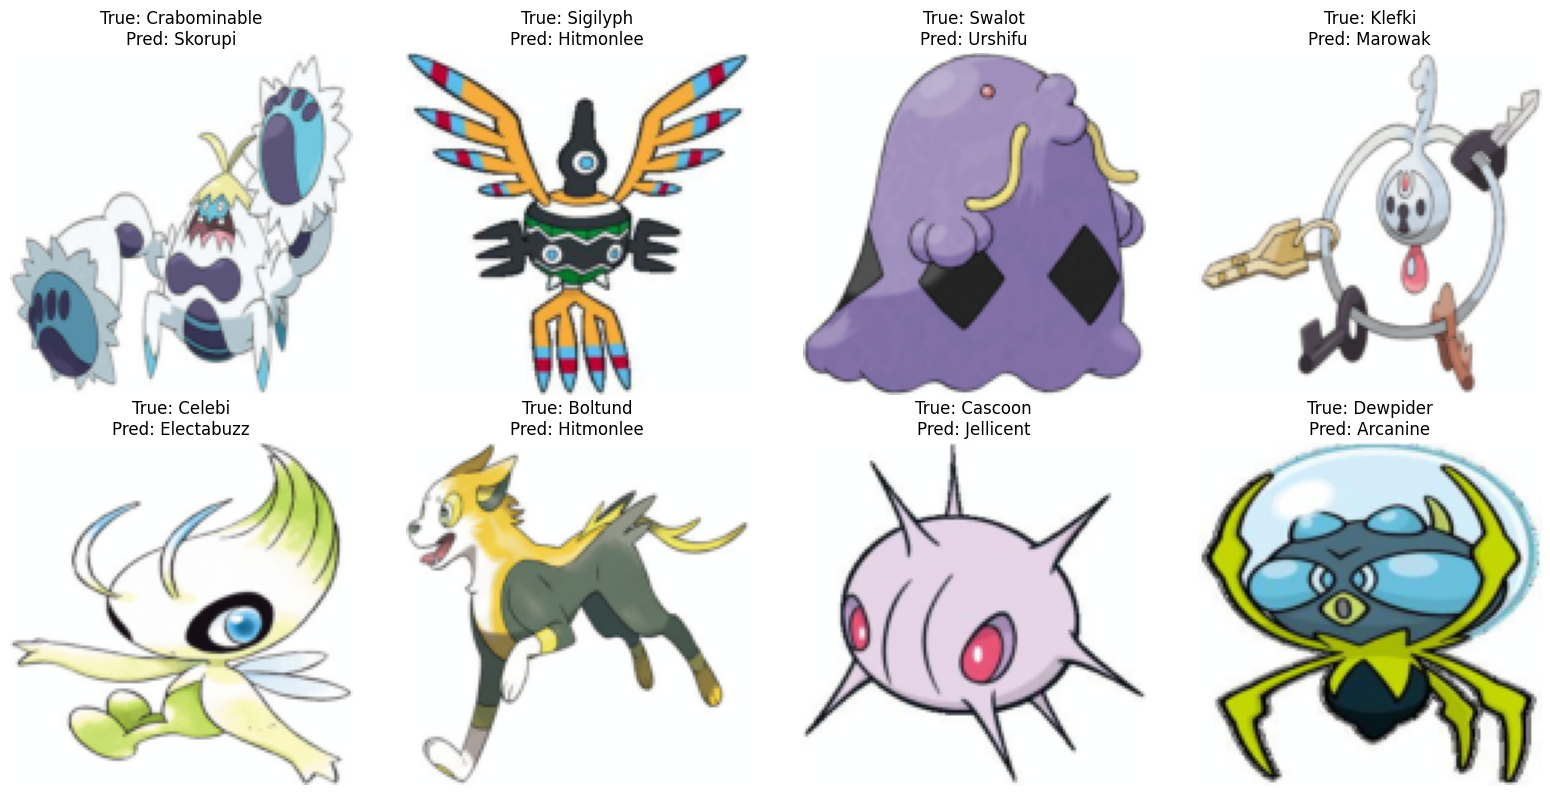

In [ ]:
test_writer = SummaryWriter(log_dir="runs/pokemon_experiment_test")

model.load_state_dict(torch.load(best_model_path))
model.eval()

test_running_loss = 0.0
test_running_corrects = 0
test_running_total = 0

all_test_preds = []
all_test_labels = []
all_test_images = []

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(tqdm(test_loader, desc="TEST evaluation")):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        preds = torch.argmax(outputs, dim=1)
        test_running_loss += loss.item() * inputs.size(0)
        test_running_corrects += torch.sum(preds == labels).item()
        test_running_total += labels.size(0)

        all_test_preds.extend(preds.cpu().tolist())
        all_test_labels.extend(labels.cpu().tolist())
        all_test_images.extend(inputs.cpu())

    test_loss = test_running_loss / test_running_total
    test_acc  = test_running_corrects / test_running_total

test_writer.add_scalar("Loss/test", test_loss, 0)
test_writer.add_scalar("Accuracy/test", test_acc, 0)

sample_imgs = torch.stack(all_test_images[:16])
img_grid = torchvision.utils.make_grid(sample_imgs, normalize=True, scale_each=True)
test_writer.add_image("Test/Images_sample", img_grid, 0)

test_writer.close()

print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}\n")

def imshow_tensor(img_tensor, title=None):
    img = img_tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")

num_to_show = 8
indices_to_show = random.sample(range(len(all_test_images)), num_to_show)

plt.figure(figsize=(16, 8))
for idx_i, idx in enumerate(indices_to_show):
    img_tensor = all_test_images[idx]
    true_label = full_dataset.classes[all_test_labels[idx]]
    pred_label = full_dataset.classes[all_test_preds[idx]]
    subtitle = f"True: {true_label}\nPred: {pred_label}"
    plt.subplot(2, 4, idx_i + 1)
    imshow_tensor(img_tensor, title=subtitle)
plt.tight_layout()
plt.show()

In [ ]:
final_model_path = "final_pokemon_cnn.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Финальная модель сохранена в {final_model_path}")

Финальная модель сохранена в final_pokemon_cnn.pth


выводы
на 10 эпохах получили точность 0.04, что на самом деле очень грустно

что можно сделать лучше?

все классические способы - увеличить кол-во слоев свертки, улучшить предобработку, увеличить кол-во эпох, перебрать гипперпараметры

еще есть подозрения, что 10 эпох слишком мало чтоб сойтись с лр 1е-4

упд.

на 20 эпохах получил - 0.06, а значит есть куда улучшаться)